In [1]:
import glob, serial, time, math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from skimage.transform import iradon
from IPython.display import display

In [2]:
ports = glob.glob('/dev/tty[A-Za-z]*') # Modify if on a platform other than Linux
ports[0]

'/dev/ttyACM1'

In [3]:
ser = serial.Serial(ports[0], 115200)

In [4]:
a_steps = 640 # Steps per revolution - 200 * 80/25
b_steps = 1280 # 160 teeth -> 200*160/25

apos = 0
bpos = 0

read = ''

def step_a(n):
    message = b'a'
    if n < 0:
        n = -n
        message = b'A'
    for i in range(n):
        ser.write(message)
        while ser.in_waiting < 1:
            pass # wait for a response
        read = ser.read_all()
#         print(read)
    return n

def set_a(angle):
    step_coords = int(angle/(2*math.pi) * a_steps) # Angle in radians
    step_a(step_coords - apos)
    return step_coords

def step_b(n):
    message = b'b'
    if n < 0:
        n = -n
        message = b'B'
    for i in range(n):
        ser.write(message)
        while ser.in_waiting < 1:
            pass # wait for a response
        read = ser.read_all()
#         print(read)
    return n

def set_b(angle):
    step_coords = int(angle/(2*math.pi) * b_steps) # Angle in radians
    step_b(step_coords - bpos)
    return step_coords

def read_adc():
    ser.write(b'E')
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

def read_adc16():
    ser.write(b'H')
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

# apos = set_a(0.2) # This is the proper usage to keep track
# print(apos)

We can move the A and B axes with step_a(n_steps) or set_a(angle in radians). A is the inner circle, B the outer.

In [5]:
step_a(10)

10

Let's take one really detailed scan using the B axis to see what our beam shape looks like. 0 to 180 degrees by stepping B 640 times (half a revolution) reading the adc 3 times each position and averaging:

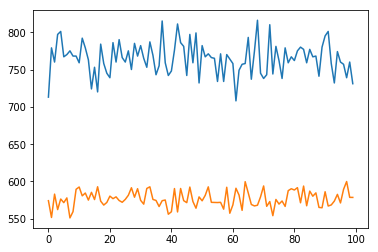

In [493]:
noise = []
s10 = []
for b in range(100):
    val = 0
    for i in range(1):
        val += int(read_adc().strip())
    noise.append(val)
    val2 = 0
    for i in range(1):
        val2 += int(read_adc16().strip())
    s10.append(val2/15)
plt.plot(noise)
plt.plot(s10)

In [502]:
ser.read_all()

b'684\r\n'

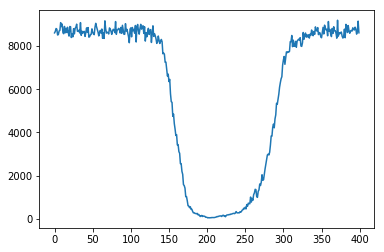

In [504]:
# Taking one set of readings as a baseline (no object)
step_b(-400)
base = []
for b in range(400):
    base.append(int(read_adc16().strip()))
    step_b(1)
                
plt.plot(base)
b = pd.DataFrame(base)
b.to_csv('lighter_base.csv', index = False)

In [524]:
step_a(-2)

2

In [526]:
# Now, doing these scans from several angles. Doing 32 As (views/thetas), 64 Bs for each A (64 sensors)
readings = []
for a in range(64):
    line = []
    for b in range(400):
        line.append(int(read_adc16().strip()))
        step_b(1)
    readings.append(line)
    step_a(10) # A has 640 steps in 360 degrees. Scanning from 32 different views
    step_b(-400) # return to start
    print(a)

# We return A to start to ensure we haven't missed steps    
step_a(-640)  

# Save the scan
d = pd.DataFrame(readings)
d.to_csv('nails2_64v_400d.csv', index=False)

0
1


KeyboardInterrupt: 

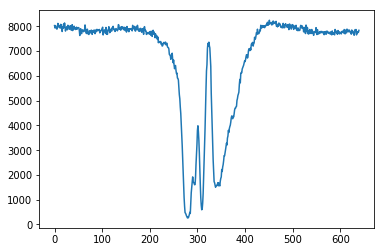

In [410]:
plt.plot(readings[0])

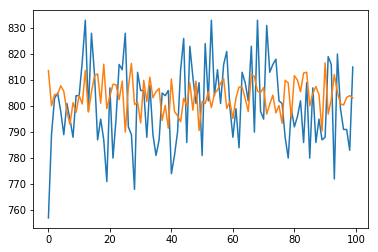

In [418]:
plt.plot(noise)
plt.plot(s10)

In [412]:
n = pd.DataFrame({'A':noise, 'B':s10})

In [416]:
n.describe()

,A,B
count,100.00000,100.000000
mean,800.70000,803.698000
std,15.65183,6.164463
min,757.00000,790.000000
25%,788.75000,800.100000
50%,801.00000,803.900000
75%,813.00000,808.250000
max,833.00000,816.600000


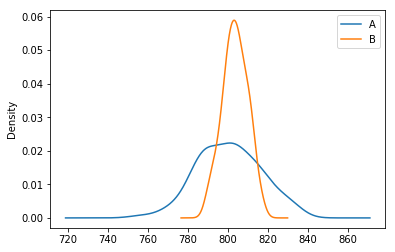

In [417]:
n.plot(kind='density')